In [3]:
import numpy as np

In [30]:
alpha = np.load("../data/1400nm/alpha.out.npy").view(dtype=np.complex128).flatten()
beta  = np.load("../data/1400nm/beta.out.npy").view(dtype=np.complex128).flatten()
l = alpha / beta

/tmp/ipykernel_1336/104830250.py:3: RuntimeWarning: divide by zero encountered in true_divide
  l = alpha / beta


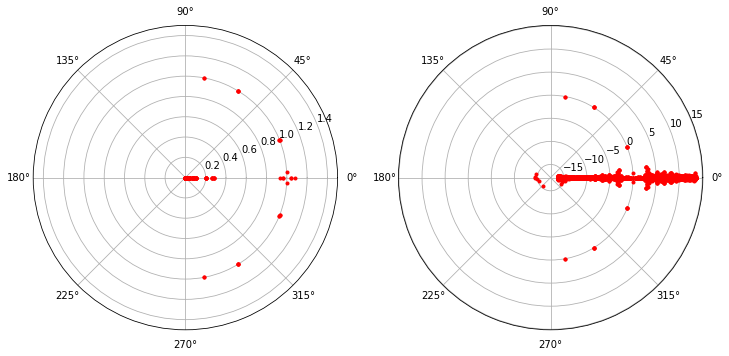

In [31]:
import matplotlib.pyplot as plt
shell_radius = 1e-10
fig, (ax1,ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 8))
ax1.plot(np.angle(l), np.abs(l), 'r.', label="EigenValues")
ax1.fill_between(np.linspace(0, 2*np.pi), 1.0-shell_radius, 1.0+shell_radius, alpha=0.5, label="On-Shell")
ax1.set_rmax(1.5)
ax2.plot(np.angle(l), np.log10(np.abs(l)), 'r.')

In [32]:
vr = np.load("../data/1400nm/vl.out.npy").view(dtype=np.complex128)
vr = vr.reshape(vr.shape[:-1])
mask = np.abs(np.abs(l) - 1.0) < shell_radius
mask = np.logical_and(mask, np.imag(l) >= 0)
vr = vr[:, mask]
print("Eigenmodes count: ", np.count_nonzero(mask))
print(l[mask])

Eigenmodes count:  11
[0.17962587+0.983735j   0.17958973+0.9837416j  0.52180247+0.85306634j
 0.52238744+0.85270825j 0.52266188+0.85254006j 0.5226656 +0.85253778j
 0.92735117+0.37419222j 0.9275068 +0.37380628j 0.92787468+0.37289218j
 0.92777905+0.37313006j 0.99860767+0.05275156j]


(14400, 14400)


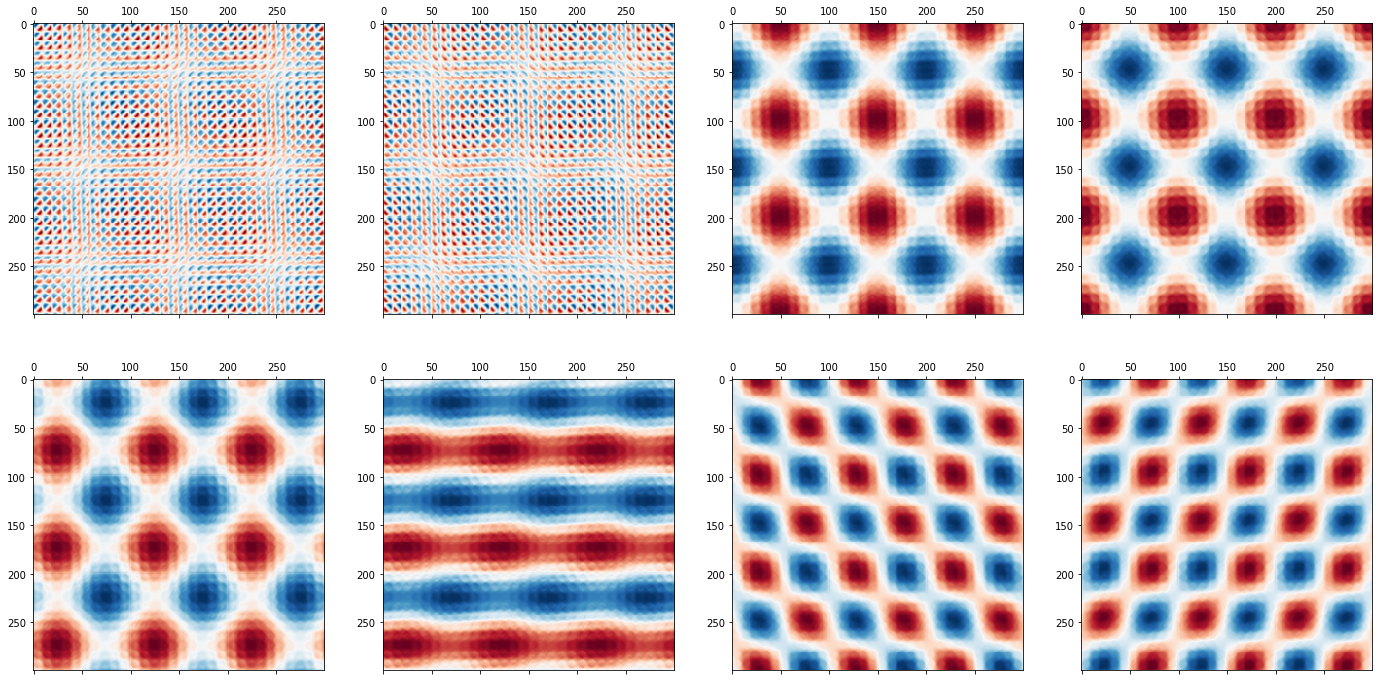

In [33]:
import sys
sys.path.append('..')
from bast.tools import nanometers
from bast.lattice import CartesianLattice
from itertools import product
from numpy import matlib as ml
from bast.tools import mu0, c

a = nanometers(100)
wavelength = nanometers(600)
pw = (60, 60)
theta = 0
phi = 0
lattice = CartesianLattice(pw, a1=(a*10, 0.0), a2=(0.0, a*10), eps_emerg=1.0)
print(lattice.U(wavelength, theta, phi).shape)
Vi = lattice.Vi(wavelength, theta, phi)
resolution =(100, 100)

num_modes = min(vr.shape[1], 8)
fig, axs = plt.subplots(num_modes//3,4 , figsize=(24,12))
axs = axs.flat
kx, ky = lattice.kp(wavelength, theta, phi)

ng = pw[0]*pw[1]
for i in range(num_modes):
    P = vr[:,i]
    P = Vi @ P
    Exg, Eyg, Hxg, Hyg = np.split(P, 4)
    ng = Exg.shape[0]
    mulx = 5
    muly = 5
    vx = np.linspace(-mulx*a, muly*a, resolution[0])
    vy = np.linspace(-mulx*a, muly*a, resolution[1])
    ux = kx + lattice.gx.T.flatten()
    uy = ky + lattice.gy.T.flatten()
    xy = np.asarray(list(product(vx, vy))).reshape(*resolution, 2)
    uxy_x = np.outer(ux, xy[:,:,0]).reshape(ng, *resolution)
    uxy_y = np.outer(uy, xy[:,:,1]).reshape(ng, *resolution)
    fxy = np.exp(1j*(uxy_x+uxy_y))
    Ex = np.sum(Exg.reshape(ng, 1, 1) * fxy, axis=0)
    Ey = np.sum(Eyg.reshape(ng, 1, 1) * fxy, axis=0)
    Hx = np.sum(Hxg.reshape(ng, 1, 1) * fxy, axis=0)
    Hy = np.sum(Hyg.reshape(ng, 1, 1) * fxy, axis=0)
    Hzg = 1 / mu0 / 2 / np.pi / c * wavelength * (ux * Eyg - uy*Exg)
    Hz = np.sum(Hzg.reshape(ng, 1, 1) * fxy, axis=0)
    #axs[i].set_title(f"{round(VVV.real, 3), round(VVV.imag, 3)}")
    axs[i].matshow(ml.repmat(Hz.real.reshape(resolution), 3, 3), cmap="RdBu")
    #axs[i].matshow(ml.repmat((np.abs(Ex*Hy-Ey*Hx)).reshape(resolution), 1, 1), cmap="RdBu")
    #axs[i].matshow(np.load("im1.npy"), alpha=0.5)
plt.savefig("Eigenmodes.png")

In [20]:
np.max(np.angle(l)) / np.pi

0.9999999999999997

In [29]:
np.rad2deg(1.389)

79.58383774367135

In [28]:
np.angle(l[mask])

array([ 1.3895935 ,  1.38963711, -1.3895935 , -1.38963711])